Question 1:

In [ ]:
import numpy as np
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score

# Generate random complex numbers
a = np.random.rand(10000) + np.random.rand(10000)*1j
b = np.random.rand(10000) + np.random.rand(10000)*1j

# Generate random arithmetic operations
ops = np.random.choice(['+', '-', '*', '/'], 10000)

# Perform the arithmetic operations on the complex numbers
c = np.zeros(10000, dtype=np.complex_)
for i in range(10000):
    if ops[i] == '+':
        c[i] = a[i] + b[i]
    elif ops[i] == '-':
        c[i] = a[i] - b[i]
    elif ops[i] == '*':
        c[i] = a[i] * b[i]
    elif ops[i] == '/':
        c[i] = a[i] / b[i]

enc = OneHotEncoder()
ops_onehot = enc.fit_transform(ops.reshape(-1, 1)).toarray()

# Create the dataset
data = np.column_stack((np.real(a), np.imag(a), np.real(b), np.imag(b), ops_onehot))
labels = np.column_stack((np.real(c), np.imag(c)))

# Save the dataset 
np.savetxt('dataset.csv', np.hstack((data, labels)), delimiter=',')

# Define the model
model = MLPRegressor(hidden_layer_sizes=(16, 16), activation='relu', solver='adam', max_iter=500)


model.fit(data, labels)

# Generate random test data
test_a = np.random.rand(100) + np.random.rand(100)*1j
test_b = np.random.rand(100) + np.random.rand(100)*1j
test_ops = np.random.choice(['+', '-', '*', '/'], 100)
test_c = np.zeros(100, dtype=np.complex_)
for i in range(100):
    if test_ops[i] == '+':
        test_c[i] = test_a[i] + test_b[i]
    elif test_ops[i] == '-':
        test_c[i] = test_a[i] - test_b[i]
    elif test_ops[i] == '*':
        test_c[i] = test_a[i] * test_b[i]
    elif test_ops[i] == '/':
        test_c[i] = test_a[i] / test_b[i]

test_ops_onehot = enc.transform(test_ops.reshape(-1, 1)).toarray()
test_a_real = np.real(test_a)
test_a_imag = np.imag(test_a)
test_b_real = np.real(test_b)
test_b_imag = np.imag(test_b)
test_data = np.column_stack((test_a_real, test_a_imag, test_b_real, test_b_imag, test_ops_onehot))


pred = model.predict(test_data)
pred_real = pred[:, 0]
pred_imag = pred[:, 1]

test_mse = mean_squared_error(np.concatenate((test_a_real + test_b_real, test_a_imag + test_b_imag)), np.concatenate((pred_real, pred_imag)))
test_r2 = r2_score(np.concatenate((test_a_real + test_b_real, test_a_imag + test_b_imag)), np.concatenate((pred_real, pred_imag)))


# Evaluate the performance of the model
mse = mean_squared_error(labels, model.predict(data))
r2 = r2_score(labels, model.predict(data))
print(f"Performance:\nMSE: {mse:.4f}, R-squared: {r2:.4f}")

# print(f"Testing set performance:\nMSE: {test_mse:.4f}, R-squared: {test_r2:.4f}")

Performance:
MSE: 0.0464, R-squared: 0.9238


Question 2:

In [ ]:
import numpy as np
from collections import Counter
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
iris = load_iris()
X = iris.data[:, 2:] 
y = iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
def entropy(y):
  hist = np.bincount(y)
  ps = hist/len(y)
  return(-np.sum([p * np.log2(p) for p in ps if p>0]))

In [ ]:
class Node:
  def __init__(self, feature=None, threshold=None, left=None, right=None,*,value=None):
    self.feature = feature
    self.threshold = threshold
    self.left = left
    self.right = right
    self.value = value
  
  def is_leaf_node(self):
    return(self.value is not None)

In [ ]:
class DecisionTree:
  def __init__(self, min_samples_split=2, max_depth=100, n_feats=None):
    self.min_samples_split = min_samples_split
    self.max_depth = max_depth
    self.n_feats = n_feats
    self.root = None

  def fit(self, X, y):
    self.n_feats = X.shape[1] if not self.n_feats else min(self.n_feats, X.shape[1])
    self.root = self._grow_tree(X, y)

  def _grow_tree(self, X, y, depth=0):
    n_samples, n_features = X.shape
    n_labels = len(np.unique(y))

    #stopping criteria
    if(depth >= self.max_depth or n_labels == 1 or n_samples < self.min_samples_split):
      leaf_value = self._most_common_label(y)
      return(Node(value=leaf_value))
    
    feat_idxs = np.random.choice(n_features, self.n_feats, replace=False)

    #greedy search
    best_feat, best_thresh = self._best_criteria(X, y, feat_idxs)

    left_idxs, right_idxs = self._split(X[:,best_feat],best_thresh)

    left = self._grow_tree(X[left_idxs,:], y[left_idxs], depth+1)
    right = self._grow_tree(X[right_idxs,:], y[right_idxs], depth+1)
    return(Node(best_feat, best_thresh, left, right))

  def _best_criteria(self, X, y, feat_idxs):
    best_gain = -1
    split_idx, split_thresh = None, None
    for feat_idx in feat_idxs:
      X_column = X[:, feat_idx]
      thresholds = np.unique(X_column)
      for threshold in thresholds:
        gain = self._information_gain(y, X_column, threshold)
        if(gain>best_gain):
          best_gain = gain
          split_idx = feat_idx
          split_thresh = threshold
    return(split_idx, split_thresh)
  
  def _information_gain(self, y, X_column, split_threh):
    #parent entropy
    parent_entropy = entropy(y)

    #generate split
    left_idxs, right_idxs = self._split(X_column, split_threh)
    if(len(left_idxs == 0) or len(right_idxs)==0):
      return 0

    #weighted avg vhild entropy
    n = len(y)
    n_l, n_r = len(left_idxs), len(right_idxs)
    e_l, e_r = entropy(y[left_idxs]), entropy(y[right_idxs])
    child_entropy = (n_l/n)*e_l + (n_r/n)*e_r

    #return ig
    ig = parent_entropy - child_entropy

    return ig

  def _split(self, X_column, split_threh):
    left_idxs = np.argwhere(X_column <= split_threh).flatten()
    right_idxs = np.argwhere(X_column > split_threh).flatten()
    return(left_idxs, right_idxs)

  def predict(self, X):
    #traverse tree
    return(np.array([self._traverse_tree(x, self.root) for x in X]))

  def _traverse_tree(self, x, node):
    if(node.is_leaf_node()):
      return(node.value)

    if(x[node.feature] <= node.threshold):
      return(self._traverse_tree(x, node.left))
    return(self._traverse_tree(x, node.right))

  def _most_common_label(self, y):
    counter = Counter(y)
    most_common = counter.most_common(1)[0][0]
    return(most_common)

In [ ]:
decTree = DecisionTree(max_depth=8)
fit_decTree = decTree.fit(X_train, y_train)

In [ ]:
y_pred = decTree.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.2f}")

Accuracy: 0.63


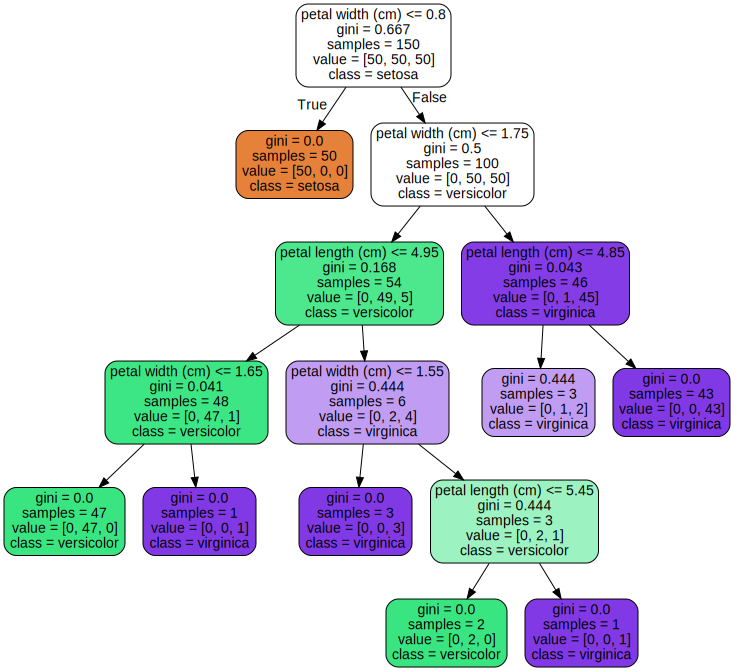

In [ ]:
from sklearn.tree import export_graphviz
import graphviz

decTree = DecisionTreeClassifier(max_depth=8)
decTree.fit(X, y)

dot_data = export_graphviz(decTree, out_file=None, 
                           feature_names=iris.feature_names[2:],
                           class_names=iris.target_names,
                           rounded=True, filled=True)

graph = graphviz.Source(dot_data)
graph

Question 3:

In [ ]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error

df = pd.read_csv("/content/drive/MyDrive/mt.csv")
df 
X = df[df.columns[:-1]]
X = np.array(X)
y1 = df[df.columns[-1]]
y1 =np.array(y1)
y1 = np.array(y1).reshape(-1, 1)
y2 = np.mean(X, axis=1) # labels for regression

# Splitting the data into train and validation sets
X_train, X_val, y1_train, y1_val, y2_train, y2_val = train_test_split(X, y1, y2, test_size=0.2, random_state=42)

# Defining the network architecture
n_input = 2 # number of inputs
n_hidden1 = 5 # number of hidden units in the first layer
n_hidden2 = 4 # number of hidden units in the second layer
n_output1 = 3 # number of outputs for classification
n_output2 = 1 # number of outputs for regression


W1 = np.random.randn(n_input, n_hidden1) # weights from input to hidden1
b1 = np.random.randn(n_hidden1) # biases for hidden1 [similarly for the biases and weights below]
W2 = np.random.randn(n_hidden1, n_hidden2) 
b2 = np.random.randn(n_hidden2) 
W3 = np.random.randn(n_hidden2, n_output1) 
b3 = np.random.randn(n_output1) 
W4 = np.random.randn(n_hidden2, n_output2) 
b4 = np.random.randn(n_output2) 

def sigmoid(x):
  x = np.clip(x, -500, 500) # clipping the input to avoid overflow
  return 1 / (1 + np.exp(-x))

def sigmoid_prime(x):
  return sigmoid(x) * (1 - sigmoid(x))

def tanh(x):
  return np.tanh(x)

def tanh_prime(x):
  return 1 - tanh(x)**2

# Loss functions
def cross_entropy(y_true, y_pred):
  y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15) # clipping the output to avoid underflow and log(0)
  return -np.sum(y_true * np.log(y_pred))

def cross_entropy_prime(y_true, y_pred):
  return -y_true / y_pred

def mse(y_true, y_pred):
  return np.mean((y_true - y_pred)**2)

def mse_prime(y_true, y_pred):
  return -2 * (y_true - y_pred)


lr = 0.01 
epochs = 100 # number of epochs


alpha = 0.5 # weight for classification loss
beta = 0.5 # weight for regression loss

# Training the network using stochastic gradient descent
for epoch in range(epochs):
  # Shuffling the training data
  idx = np.random.permutation(len(X_train))
  X_train = X_train[idx]
  y1_train = y1_train[idx]
  y2_train = y2_train[idx]

  # Looping over each training example
  for i in range(len(X_train)):
    # Forward propogation
    x = X_train[i][:n_input] # input vector 
    y_true1 = y1_train[i] # true label for classification
    y_true2 = y2_train[i] # true label for regression

    z1 = x.dot(W1) + b1 # linear combination for hidden1
    a1 = sigmoid(z1) # activation for hidden1

    z2 = a1.dot(W2) + b2 
    a2 = tanh(z2) 

    z3 = a2.dot(W3) + b3 # linear combination for output1
    a3 = sigmoid(z3) # activation for output1 

    z4 = a2.dot(W4) + b4 # linear combination for output2
    a4 = z4 # activation for output2 

    L1 = cross_entropy(y_true1, a3) # classification loss
    L2 = mse(y_true2, a4) # regression loss
    L = alpha * L1 + beta * L2 # total loss

    # Backward propogation
    # Computing the gradients for output2
    dL_dz4 = mse_prime(y_true2, a4) # gradient of loss w.r.t. z4
    dL_dW4 = a2.reshape(-1, 1).dot(dL_dz4.reshape(1, -1)) # gradient of loss w.r.t. W4
    dL_db4 = dL_dz4 # gradient of loss w.r.t. b4
    dL_da2 = dL_dz4.dot(W4.T) # gradient of loss w.r.t. a2

    # Computing the gradients for output1
    dL_dz3 = cross_entropy_prime(y_true1, a3) * sigmoid_prime(z3) 
    dL_dW3 = a2.reshape(-1,1).dot(dL_dz3.reshape(1,-1)) 
    dL_db3 = np.sum(dL_dz3, axis=0) 
    dL_da2 += dL_dz3.dot(W3.T) 

    # Computing the gradients for hidden2
    dL_dz2 = dL_da2 * tanh_prime(z2) # gradient of loss w.r.t. z2
    dL_dW2 = a1.reshape(-1,1).dot(dL_dz2.reshape(1,-1)) # gradient of loss w.r.t. W2
    dL_db2 = np.sum(dL_dz2, axis=0) # gradient of loss w.r.t. b2
    dL_da1 = dL_dz2.dot(W2.T) # gradient of loss w.r.t. a1

    # Computing the gradients for hidden1
    dL_dz1 = dL_da1 * sigmoid_prime(z1) 
    dL_dW1 = x.reshape(-1,1).dot(dL_dz1.reshape(1,-1)) 
    dL_db1 = np.sum(dL_dz1, axis=0) 

    # Updating the parameters using gradient descent
    W1 -= lr * dL_dW1
    b1 -= lr * dL_db1
    W2 -= lr * dL_dW2
    b2 -= lr * dL_db2
    W3 -= lr * dL_dW3
    b3 -= lr * dL_db3
    W4 -= lr * dL_dW4
    b4 -= lr * dL_db4

  
  y_pred1 = [] # predictions for classification
  y_pred2 = [] # predictions for regression

  for j in range(len(X_val)):
    x = X_val[j][:n_input] # input vector 
    
    z1 = x.dot(W1) + b1 # linear combination for hidden1
    a1 = sigmoid(z1) # activation for hidden1

    z2 = a1.dot(W2) + b2 
    a2 = tanh(z2) 

    z3 = a2.dot(W3) + b3 # linear combination for output1
    a3 = sigmoid(z3) # activation for output1 

    z4 = a2.dot(W4) + b4 # linear combination for output2
    a4 = z4 # activation for output2 

    y_pred1.append(np.argmax(a3)) 
    y_pred2.append(a4[0]) 
  
  acc = accuracy_score(y1_val.argmax(axis=1), y_pred1) 
  rmse = np.sqrt(mean_squared_error(y2_val, y_pred2)) 

  print(f"Epoch {epoch+1}, Loss: {L:.3f}, Accuracy: {acc:.3f}, RMSE: {rmse:.3f}")

Epoch 1, Loss: 0.116, Accuracy: 0.333, RMSE: 0.894
Epoch 2, Loss: 0.425, Accuracy: 0.333, RMSE: 0.599
Epoch 3, Loss: 0.027, Accuracy: 0.467, RMSE: 0.360
Epoch 4, Loss: 0.205, Accuracy: 0.433, RMSE: 0.218
Epoch 5, Loss: 0.041, Accuracy: 0.600, RMSE: 0.187
Epoch 6, Loss: 0.057, Accuracy: 0.600, RMSE: 0.193
Epoch 7, Loss: 0.007, Accuracy: 0.667, RMSE: 0.155
Epoch 8, Loss: 0.073, Accuracy: 0.667, RMSE: 0.147
Epoch 9, Loss: 0.038, Accuracy: 0.667, RMSE: 0.125
Epoch 10, Loss: 0.016, Accuracy: 0.733, RMSE: 0.132
Epoch 11, Loss: 0.024, Accuracy: 0.733, RMSE: 0.114
Epoch 12, Loss: 0.003, Accuracy: 0.733, RMSE: 0.109
Epoch 13, Loss: 0.016, Accuracy: 0.733, RMSE: 0.104
Epoch 14, Loss: 0.033, Accuracy: 0.733, RMSE: 0.103
Epoch 15, Loss: 0.016, Accuracy: 0.733, RMSE: 0.117
Epoch 16, Loss: 0.014, Accuracy: 0.733, RMSE: 0.096
Epoch 17, Loss: 0.002, Accuracy: 0.733, RMSE: 0.094
Epoch 18, Loss: 0.023, Accuracy: 0.733, RMSE: 0.097
Epoch 19, Loss: 0.019, Accuracy: 0.733, RMSE: 0.101
Epoch 20, Loss: 0.021

References:

1.   https://www.analyticsvidhya.com/blog/2020/07/neural-networks-from-scratch-in-python-and-r/
2.   https://www.freecodecamp.org/news/building-a-neural-network-from-scratch/
3. https://www.analyticsvidhya.com/blog/2020/10/all-about-decision-tree-from-scratch-with-python-implementation/



